# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

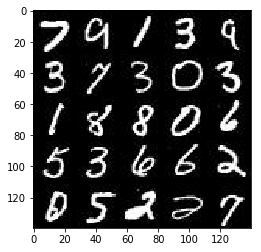

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

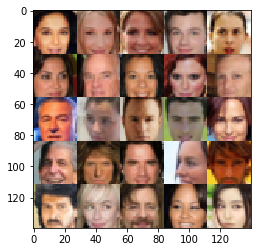

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, 
                                             image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, None, name='learn_rate')
    return input_real, input_z, learn_rate
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    stddev = 0.02
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3 or 28x28x1
        layer = tf.layers.conv2d(images, 64, (5, 5), 
                                 strides=(2, 2), 
                                 padding='same',
                                 kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer = tf.maximum(alpha*layer, layer)
        # 14x14x64
        
        layer = tf.layers.conv2d(layer, 128, (5, 5), 
                                 strides=(2, 2), 
                                 padding='same',
                                kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = tf.maximum(alpha*layer, layer)
        # 7x7x128

        layer = tf.layers.conv2d(layer, 256, (5, 5), 
                                 strides=(2, 2), 
                                 padding='same',
                                 kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = tf.maximum(alpha*layer, layer)
        # 4x4x256
        
        layer = tf.reshape(layer, (-1, 4*4*256))
        logits = tf.layers.dense(layer, 1, kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # use normal ReLu instead of leaky Relu, as recommended in the original paper
    
    #alpha = 0.2
    stddev = 0.02
    with tf.variable_scope('generator', reuse=not is_train):
        layer = tf.layers.dense(z, 7*7*256, kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer = tf.reshape(layer, (-1, 7, 7, 256))
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.nn.relu(layer)
        #layer = tf.maximum(alpha*layer, layer)
        # 7x7x256
        
        layer = tf.layers.conv2d_transpose(layer, 128, (5, 5), 
                                           strides=(2, 2), 
                                           padding='same',
                                           kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.nn.relu(layer)
        #layer = tf.maximum(alpha*layer, layer)
        # 14x14x128
        
        layer = tf.layers.conv2d_transpose(layer, 64, (5, 5), 
                                           strides=(2, 2), 
                                           padding='same',
                                           kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.nn.relu(layer)
        #layer = tf.maximum(alpha*layer, layer)
        # 28x28x64
        
        # Output layer, 28x28xout_channel_dim
        logits = tf.layers.conv2d_transpose(layer, 
                                            out_channel_dim, 
                                            (5, 5), 
                                            strides=(1, 1), 
                                            padding='same',
                                            kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        out = tf.tanh(logits)
    
    return out



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.9
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=tf.ones_like(d_model_real)*smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_real)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train. \
                        AdamOptimizer(learning_rate=learning_rate, beta1=beta1). \
                            minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train. \
                        AdamOptimizer(learning_rate=learning_rate, beta1=beta1). \
                            minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # For statistic print
    steps = 0
    print_every = 25
    show_every = 100
    
    # create inputs, losses and optimizers
    input_real, input_z, learn_rate = model_inputs(*data_shape[1:4], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # reshape and re-scale bacth image
                batch_images = batch_images.reshape(batch_size, *data_shape[1:4])
                batch_images = batch_images*2
                
                # noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # run optimizers (run generator more often than discriminator)
                _ = sess.run(d_opt, 
                             feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, 
                             feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, 
                             feed_dict={input_real: batch_images, input_z: batch_z})
                
                # print losses every 25 steps
                if steps%print_every == 0:
                    train_loss_d = d_loss.eval(feed_dict={input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval(feed_dict={input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Step {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                # show generator output everz 100 steps
                if steps%show_every == 0:
                    show_generator_output(sess, 32, input_z, data_shape[3], data_image_mode)   

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 25... Discriminator Loss: 1.8334... Generator Loss: 0.6593
Epoch 1/2... Step 50... Discriminator Loss: 1.9007... Generator Loss: 0.4533
Epoch 1/2... Step 75... Discriminator Loss: 1.7031... Generator Loss: 0.6198
Epoch 1/2... Step 100... Discriminator Loss: 1.5814... Generator Loss: 0.5666


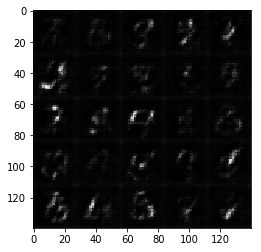

Epoch 1/2... Step 125... Discriminator Loss: 1.8114... Generator Loss: 1.7558
Epoch 1/2... Step 150... Discriminator Loss: 1.4070... Generator Loss: 0.6058
Epoch 1/2... Step 175... Discriminator Loss: 1.5887... Generator Loss: 0.7902
Epoch 1/2... Step 200... Discriminator Loss: 1.4468... Generator Loss: 0.8514


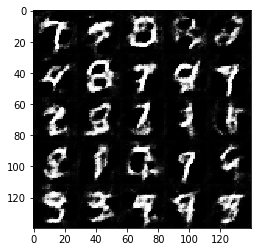

Epoch 1/2... Step 225... Discriminator Loss: 1.6085... Generator Loss: 0.4629
Epoch 1/2... Step 250... Discriminator Loss: 1.6031... Generator Loss: 0.4909
Epoch 1/2... Step 275... Discriminator Loss: 1.5262... Generator Loss: 0.5177
Epoch 1/2... Step 300... Discriminator Loss: 1.4722... Generator Loss: 0.7384


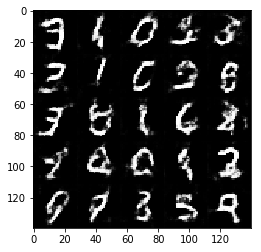

Epoch 1/2... Step 325... Discriminator Loss: 1.5965... Generator Loss: 0.4705
Epoch 1/2... Step 350... Discriminator Loss: 1.5304... Generator Loss: 0.5976
Epoch 1/2... Step 375... Discriminator Loss: 1.4729... Generator Loss: 0.6669
Epoch 1/2... Step 400... Discriminator Loss: 1.6007... Generator Loss: 0.4230


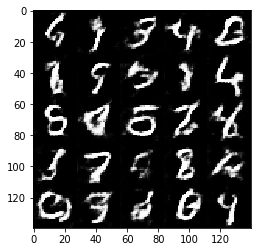

Epoch 1/2... Step 425... Discriminator Loss: 1.5941... Generator Loss: 0.4609
Epoch 1/2... Step 450... Discriminator Loss: 1.3924... Generator Loss: 0.6802
Epoch 1/2... Step 475... Discriminator Loss: 1.4708... Generator Loss: 0.5388
Epoch 1/2... Step 500... Discriminator Loss: 1.4007... Generator Loss: 0.6018


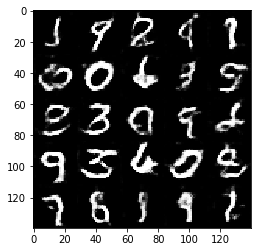

Epoch 1/2... Step 525... Discriminator Loss: 1.4274... Generator Loss: 0.8826
Epoch 1/2... Step 550... Discriminator Loss: 1.5398... Generator Loss: 0.4942
Epoch 1/2... Step 575... Discriminator Loss: 1.7067... Generator Loss: 0.3630
Epoch 1/2... Step 600... Discriminator Loss: 1.4180... Generator Loss: 0.6224


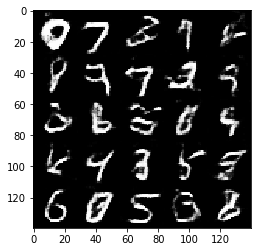

Epoch 1/2... Step 625... Discriminator Loss: 1.3989... Generator Loss: 0.7883
Epoch 1/2... Step 650... Discriminator Loss: 2.2996... Generator Loss: 0.1743
Epoch 1/2... Step 675... Discriminator Loss: 1.4383... Generator Loss: 0.7140
Epoch 1/2... Step 700... Discriminator Loss: 1.4452... Generator Loss: 0.6689


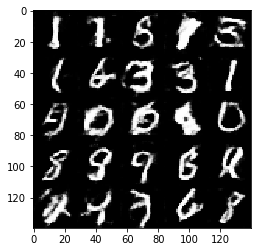

Epoch 1/2... Step 725... Discriminator Loss: 1.3170... Generator Loss: 0.7898
Epoch 1/2... Step 750... Discriminator Loss: 1.4659... Generator Loss: 0.8062
Epoch 1/2... Step 775... Discriminator Loss: 1.4439... Generator Loss: 0.6331
Epoch 1/2... Step 800... Discriminator Loss: 1.5183... Generator Loss: 0.6117


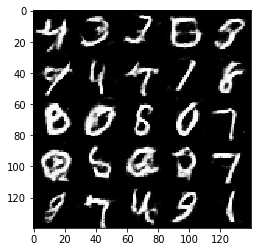

Epoch 1/2... Step 825... Discriminator Loss: 1.3700... Generator Loss: 0.7411
Epoch 1/2... Step 850... Discriminator Loss: 1.3405... Generator Loss: 0.8625
Epoch 1/2... Step 875... Discriminator Loss: 1.3772... Generator Loss: 1.1032
Epoch 1/2... Step 900... Discriminator Loss: 1.8424... Generator Loss: 1.7969


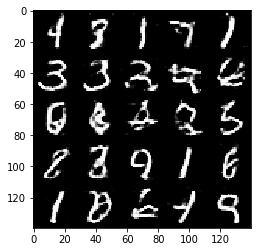

Epoch 1/2... Step 925... Discriminator Loss: 1.3208... Generator Loss: 0.7462
Epoch 2/2... Step 950... Discriminator Loss: 1.8822... Generator Loss: 0.2798
Epoch 2/2... Step 975... Discriminator Loss: 1.4443... Generator Loss: 0.5226
Epoch 2/2... Step 1000... Discriminator Loss: 1.6072... Generator Loss: 0.4413


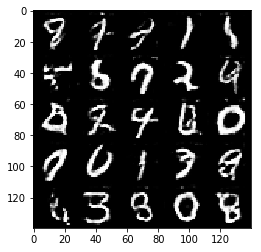

Epoch 2/2... Step 1025... Discriminator Loss: 1.6522... Generator Loss: 0.4136
Epoch 2/2... Step 1050... Discriminator Loss: 1.7682... Generator Loss: 0.3165
Epoch 2/2... Step 1075... Discriminator Loss: 1.3333... Generator Loss: 0.6309
Epoch 2/2... Step 1100... Discriminator Loss: 1.4188... Generator Loss: 0.7552


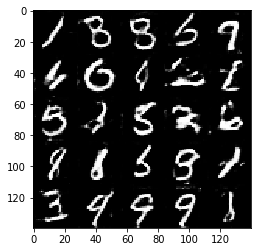

Epoch 2/2... Step 1125... Discriminator Loss: 1.4665... Generator Loss: 0.5868
Epoch 2/2... Step 1150... Discriminator Loss: 1.5849... Generator Loss: 0.4185
Epoch 2/2... Step 1175... Discriminator Loss: 1.3116... Generator Loss: 0.7684
Epoch 2/2... Step 1200... Discriminator Loss: 1.4621... Generator Loss: 0.4999


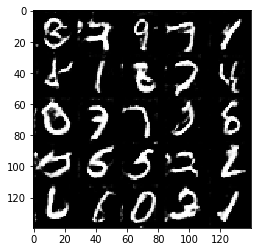

Epoch 2/2... Step 1225... Discriminator Loss: 1.4881... Generator Loss: 0.6059
Epoch 2/2... Step 1250... Discriminator Loss: 1.3941... Generator Loss: 0.6143
Epoch 2/2... Step 1275... Discriminator Loss: 1.5349... Generator Loss: 0.4675
Epoch 2/2... Step 1300... Discriminator Loss: 1.3951... Generator Loss: 0.6379


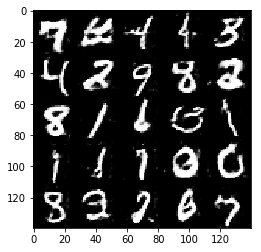

Epoch 2/2... Step 1325... Discriminator Loss: 1.3879... Generator Loss: 0.7121
Epoch 2/2... Step 1350... Discriminator Loss: 1.3129... Generator Loss: 0.6274
Epoch 2/2... Step 1375... Discriminator Loss: 1.3145... Generator Loss: 0.8715
Epoch 2/2... Step 1400... Discriminator Loss: 1.4398... Generator Loss: 0.5784


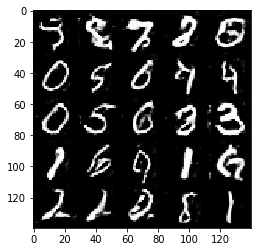

Epoch 2/2... Step 1425... Discriminator Loss: 1.3040... Generator Loss: 0.7639
Epoch 2/2... Step 1450... Discriminator Loss: 1.4346... Generator Loss: 0.5308
Epoch 2/2... Step 1475... Discriminator Loss: 1.4464... Generator Loss: 0.6098
Epoch 2/2... Step 1500... Discriminator Loss: 1.2962... Generator Loss: 0.7042


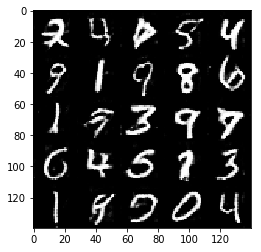

Epoch 2/2... Step 1525... Discriminator Loss: 1.3789... Generator Loss: 1.2711
Epoch 2/2... Step 1550... Discriminator Loss: 1.2989... Generator Loss: 0.9698
Epoch 2/2... Step 1575... Discriminator Loss: 1.2923... Generator Loss: 0.6488
Epoch 2/2... Step 1600... Discriminator Loss: 1.4104... Generator Loss: 0.7926


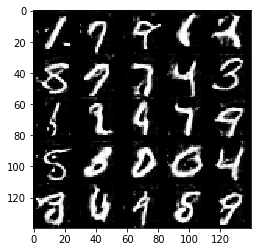

Epoch 2/2... Step 1625... Discriminator Loss: 1.3002... Generator Loss: 0.7586
Epoch 2/2... Step 1650... Discriminator Loss: 1.5702... Generator Loss: 0.4890
Epoch 2/2... Step 1675... Discriminator Loss: 1.5129... Generator Loss: 0.8402
Epoch 2/2... Step 1700... Discriminator Loss: 1.3941... Generator Loss: 0.5525


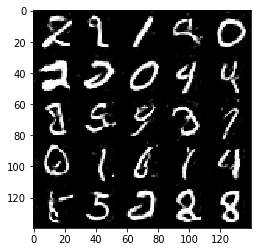

Epoch 2/2... Step 1725... Discriminator Loss: 1.3218... Generator Loss: 0.8222
Epoch 2/2... Step 1750... Discriminator Loss: 1.4362... Generator Loss: 0.6351
Epoch 2/2... Step 1775... Discriminator Loss: 1.3886... Generator Loss: 1.1775
Epoch 2/2... Step 1800... Discriminator Loss: 1.3851... Generator Loss: 0.5472


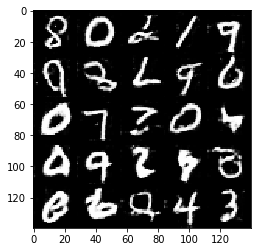

Epoch 2/2... Step 1825... Discriminator Loss: 1.3048... Generator Loss: 0.8269
Epoch 2/2... Step 1850... Discriminator Loss: 1.6694... Generator Loss: 0.9751


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step 25... Discriminator Loss: 3.2034... Generator Loss: 0.2074
Epoch 1/1... Step 50... Discriminator Loss: 2.3845... Generator Loss: 0.3651
Epoch 1/1... Step 75... Discriminator Loss: 1.8441... Generator Loss: 0.5661
Epoch 1/1... Step 100... Discriminator Loss: 1.3980... Generator Loss: 0.7140


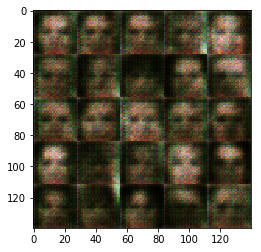

Epoch 1/1... Step 125... Discriminator Loss: 1.4397... Generator Loss: 0.7923
Epoch 1/1... Step 150... Discriminator Loss: 1.6123... Generator Loss: 0.6748
Epoch 1/1... Step 175... Discriminator Loss: 1.6284... Generator Loss: 0.6297
Epoch 1/1... Step 200... Discriminator Loss: 1.5644... Generator Loss: 0.5790


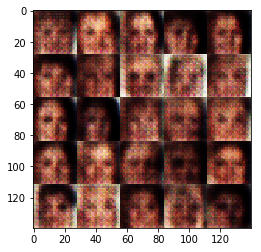

Epoch 1/1... Step 225... Discriminator Loss: 1.6003... Generator Loss: 0.6021
Epoch 1/1... Step 250... Discriminator Loss: 1.5924... Generator Loss: 0.6685
Epoch 1/1... Step 275... Discriminator Loss: 1.5437... Generator Loss: 0.6693
Epoch 1/1... Step 300... Discriminator Loss: 1.4968... Generator Loss: 0.6378


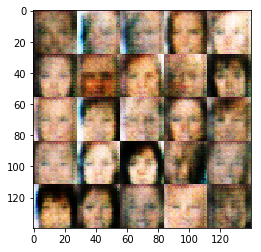

Epoch 1/1... Step 325... Discriminator Loss: 1.5602... Generator Loss: 0.6147
Epoch 1/1... Step 350... Discriminator Loss: 1.4852... Generator Loss: 0.7408
Epoch 1/1... Step 375... Discriminator Loss: 1.4543... Generator Loss: 0.7814
Epoch 1/1... Step 400... Discriminator Loss: 1.5223... Generator Loss: 0.6665


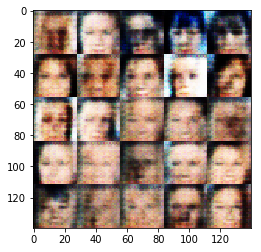

Epoch 1/1... Step 425... Discriminator Loss: 1.4978... Generator Loss: 0.6221
Epoch 1/1... Step 450... Discriminator Loss: 1.4062... Generator Loss: 0.7087
Epoch 1/1... Step 475... Discriminator Loss: 1.4600... Generator Loss: 0.6799
Epoch 1/1... Step 500... Discriminator Loss: 1.4610... Generator Loss: 0.7399


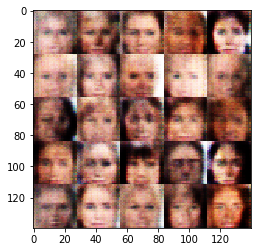

Epoch 1/1... Step 525... Discriminator Loss: 1.4784... Generator Loss: 0.6448
Epoch 1/1... Step 550... Discriminator Loss: 1.4419... Generator Loss: 0.7580
Epoch 1/1... Step 575... Discriminator Loss: 1.4937... Generator Loss: 0.6845
Epoch 1/1... Step 600... Discriminator Loss: 1.4109... Generator Loss: 0.7117


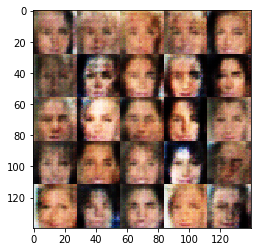

Epoch 1/1... Step 625... Discriminator Loss: 1.5223... Generator Loss: 0.6830
Epoch 1/1... Step 650... Discriminator Loss: 1.5309... Generator Loss: 0.6523
Epoch 1/1... Step 675... Discriminator Loss: 1.3733... Generator Loss: 0.8364
Epoch 1/1... Step 700... Discriminator Loss: 1.3874... Generator Loss: 0.8281


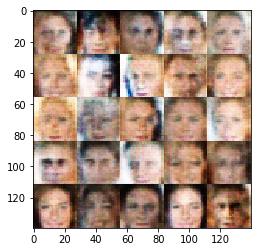

Epoch 1/1... Step 725... Discriminator Loss: 1.5006... Generator Loss: 0.6964
Epoch 1/1... Step 750... Discriminator Loss: 1.4803... Generator Loss: 0.7501
Epoch 1/1... Step 775... Discriminator Loss: 1.4059... Generator Loss: 0.7392
Epoch 1/1... Step 800... Discriminator Loss: 1.4474... Generator Loss: 0.7004


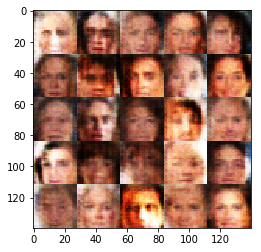

Epoch 1/1... Step 825... Discriminator Loss: 1.4582... Generator Loss: 0.8001
Epoch 1/1... Step 850... Discriminator Loss: 1.3902... Generator Loss: 0.7613
Epoch 1/1... Step 875... Discriminator Loss: 1.5371... Generator Loss: 0.6670
Epoch 1/1... Step 900... Discriminator Loss: 1.4226... Generator Loss: 0.7390


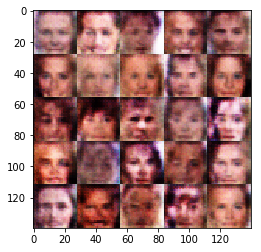

Epoch 1/1... Step 925... Discriminator Loss: 1.4274... Generator Loss: 0.7254
Epoch 1/1... Step 950... Discriminator Loss: 1.3995... Generator Loss: 0.8276
Epoch 1/1... Step 975... Discriminator Loss: 1.4498... Generator Loss: 0.7213
Epoch 1/1... Step 1000... Discriminator Loss: 1.5193... Generator Loss: 0.7048


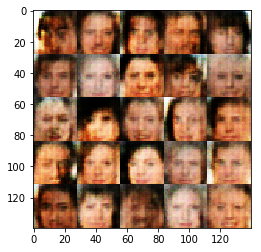

Epoch 1/1... Step 1025... Discriminator Loss: 1.3828... Generator Loss: 0.7961
Epoch 1/1... Step 1050... Discriminator Loss: 1.4262... Generator Loss: 0.7212
Epoch 1/1... Step 1075... Discriminator Loss: 1.5098... Generator Loss: 0.7995
Epoch 1/1... Step 1100... Discriminator Loss: 1.4281... Generator Loss: 0.8181


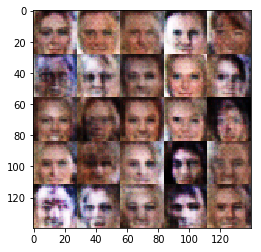

Epoch 1/1... Step 1125... Discriminator Loss: 1.4586... Generator Loss: 0.8351
Epoch 1/1... Step 1150... Discriminator Loss: 1.4147... Generator Loss: 0.7066
Epoch 1/1... Step 1175... Discriminator Loss: 1.4442... Generator Loss: 0.7488
Epoch 1/1... Step 1200... Discriminator Loss: 1.3944... Generator Loss: 0.8957


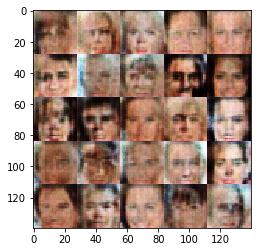

Epoch 1/1... Step 1225... Discriminator Loss: 1.4002... Generator Loss: 0.8367
Epoch 1/1... Step 1250... Discriminator Loss: 1.4653... Generator Loss: 0.8018
Epoch 1/1... Step 1275... Discriminator Loss: 1.4445... Generator Loss: 0.7656
Epoch 1/1... Step 1300... Discriminator Loss: 1.3862... Generator Loss: 0.7444


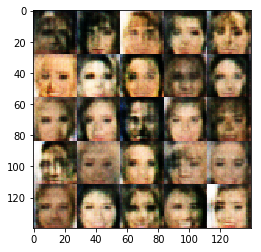

Epoch 1/1... Step 1325... Discriminator Loss: 1.3677... Generator Loss: 0.8278
Epoch 1/1... Step 1350... Discriminator Loss: 1.3885... Generator Loss: 0.7893
Epoch 1/1... Step 1375... Discriminator Loss: 1.4470... Generator Loss: 0.7000
Epoch 1/1... Step 1400... Discriminator Loss: 1.3862... Generator Loss: 0.8015


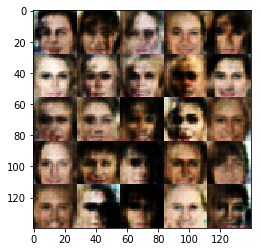

Epoch 1/1... Step 1425... Discriminator Loss: 1.4691... Generator Loss: 0.7098
Epoch 1/1... Step 1450... Discriminator Loss: 1.4297... Generator Loss: 0.7092
Epoch 1/1... Step 1475... Discriminator Loss: 1.4077... Generator Loss: 0.7977
Epoch 1/1... Step 1500... Discriminator Loss: 1.3984... Generator Loss: 0.7998


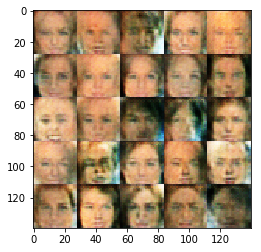

Epoch 1/1... Step 1525... Discriminator Loss: 1.4134... Generator Loss: 0.8213
Epoch 1/1... Step 1550... Discriminator Loss: 1.4450... Generator Loss: 0.7818
Epoch 1/1... Step 1575... Discriminator Loss: 1.5384... Generator Loss: 0.7103
Epoch 1/1... Step 1600... Discriminator Loss: 1.4216... Generator Loss: 0.7096


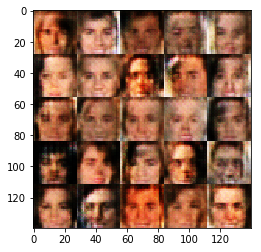

Epoch 1/1... Step 1625... Discriminator Loss: 1.4316... Generator Loss: 0.7081
Epoch 1/1... Step 1650... Discriminator Loss: 1.4487... Generator Loss: 0.7733
Epoch 1/1... Step 1675... Discriminator Loss: 1.4376... Generator Loss: 0.7392
Epoch 1/1... Step 1700... Discriminator Loss: 1.3829... Generator Loss: 0.8463


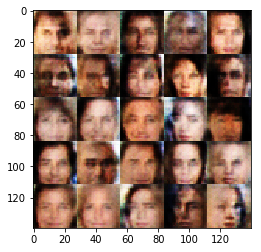

Epoch 1/1... Step 1725... Discriminator Loss: 1.4091... Generator Loss: 0.7712
Epoch 1/1... Step 1750... Discriminator Loss: 1.3882... Generator Loss: 0.7882
Epoch 1/1... Step 1775... Discriminator Loss: 1.4356... Generator Loss: 0.7731
Epoch 1/1... Step 1800... Discriminator Loss: 1.4268... Generator Loss: 0.7595


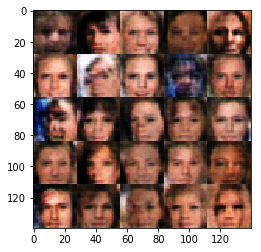

Epoch 1/1... Step 1825... Discriminator Loss: 1.4055... Generator Loss: 0.7872
Epoch 1/1... Step 1850... Discriminator Loss: 1.4440... Generator Loss: 0.7317
Epoch 1/1... Step 1875... Discriminator Loss: 1.4692... Generator Loss: 0.6933
Epoch 1/1... Step 1900... Discriminator Loss: 1.4036... Generator Loss: 0.7268


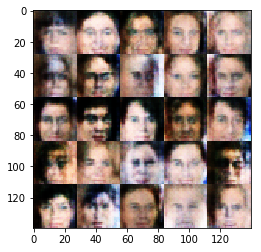

Epoch 1/1... Step 1925... Discriminator Loss: 1.4501... Generator Loss: 0.6915
Epoch 1/1... Step 1950... Discriminator Loss: 1.4506... Generator Loss: 0.7483
Epoch 1/1... Step 1975... Discriminator Loss: 1.4695... Generator Loss: 0.6640
Epoch 1/1... Step 2000... Discriminator Loss: 1.4388... Generator Loss: 0.6902


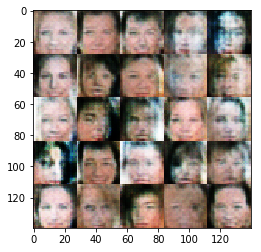

Epoch 1/1... Step 2025... Discriminator Loss: 1.3658... Generator Loss: 0.8065
Epoch 1/1... Step 2050... Discriminator Loss: 1.4533... Generator Loss: 0.6887
Epoch 1/1... Step 2075... Discriminator Loss: 1.4114... Generator Loss: 0.7099
Epoch 1/1... Step 2100... Discriminator Loss: 1.3686... Generator Loss: 0.7242


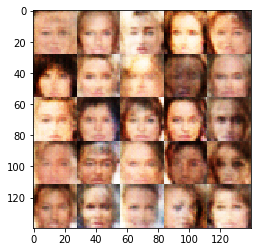

Epoch 1/1... Step 2125... Discriminator Loss: 1.4027... Generator Loss: 0.8223
Epoch 1/1... Step 2150... Discriminator Loss: 1.4542... Generator Loss: 0.7120
Epoch 1/1... Step 2175... Discriminator Loss: 1.4216... Generator Loss: 0.7785
Epoch 1/1... Step 2200... Discriminator Loss: 1.4253... Generator Loss: 0.7401


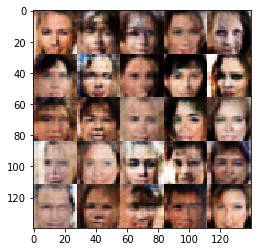

Epoch 1/1... Step 2225... Discriminator Loss: 1.4111... Generator Loss: 0.7958
Epoch 1/1... Step 2250... Discriminator Loss: 1.4221... Generator Loss: 0.7576
Epoch 1/1... Step 2275... Discriminator Loss: 1.4271... Generator Loss: 0.7160
Epoch 1/1... Step 2300... Discriminator Loss: 1.4130... Generator Loss: 0.7548


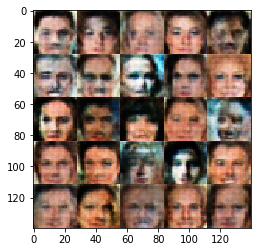

Epoch 1/1... Step 2325... Discriminator Loss: 1.4542... Generator Loss: 0.7325
Epoch 1/1... Step 2350... Discriminator Loss: 1.3911... Generator Loss: 0.7687
Epoch 1/1... Step 2375... Discriminator Loss: 1.4850... Generator Loss: 0.6812
Epoch 1/1... Step 2400... Discriminator Loss: 1.4245... Generator Loss: 0.6908


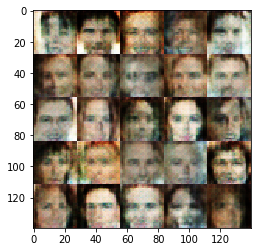

Epoch 1/1... Step 2425... Discriminator Loss: 1.3800... Generator Loss: 0.7672
Epoch 1/1... Step 2450... Discriminator Loss: 1.4283... Generator Loss: 0.7592
Epoch 1/1... Step 2475... Discriminator Loss: 1.4061... Generator Loss: 0.7307
Epoch 1/1... Step 2500... Discriminator Loss: 1.3866... Generator Loss: 0.7973


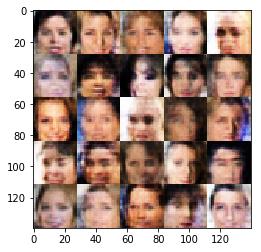

Epoch 1/1... Step 2525... Discriminator Loss: 1.3955... Generator Loss: 0.7563
Epoch 1/1... Step 2550... Discriminator Loss: 1.4119... Generator Loss: 0.7767
Epoch 1/1... Step 2575... Discriminator Loss: 1.3824... Generator Loss: 0.8519
Epoch 1/1... Step 2600... Discriminator Loss: 1.4362... Generator Loss: 0.6658


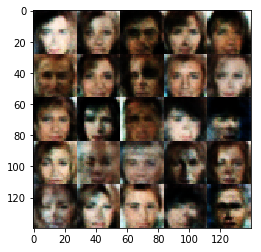

Epoch 1/1... Step 2625... Discriminator Loss: 1.4335... Generator Loss: 0.8085
Epoch 1/1... Step 2650... Discriminator Loss: 1.4255... Generator Loss: 0.7948
Epoch 1/1... Step 2675... Discriminator Loss: 1.4162... Generator Loss: 0.7335
Epoch 1/1... Step 2700... Discriminator Loss: 1.3773... Generator Loss: 0.7741


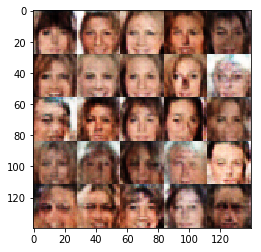

Epoch 1/1... Step 2725... Discriminator Loss: 1.4238... Generator Loss: 0.6917
Epoch 1/1... Step 2750... Discriminator Loss: 1.3814... Generator Loss: 0.7621
Epoch 1/1... Step 2775... Discriminator Loss: 1.4152... Generator Loss: 0.7243
Epoch 1/1... Step 2800... Discriminator Loss: 1.4190... Generator Loss: 0.8579


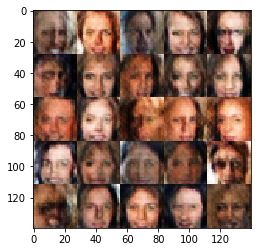

Epoch 1/1... Step 2825... Discriminator Loss: 1.4036... Generator Loss: 0.7835
Epoch 1/1... Step 2850... Discriminator Loss: 1.3902... Generator Loss: 0.7439
Epoch 1/1... Step 2875... Discriminator Loss: 1.4536... Generator Loss: 0.7413
Epoch 1/1... Step 2900... Discriminator Loss: 1.3941... Generator Loss: 0.7912


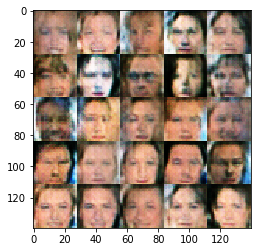

Epoch 1/1... Step 2925... Discriminator Loss: 1.4081... Generator Loss: 0.7472
Epoch 1/1... Step 2950... Discriminator Loss: 1.4462... Generator Loss: 0.7195
Epoch 1/1... Step 2975... Discriminator Loss: 1.3982... Generator Loss: 0.7096
Epoch 1/1... Step 3000... Discriminator Loss: 1.3958... Generator Loss: 0.7797


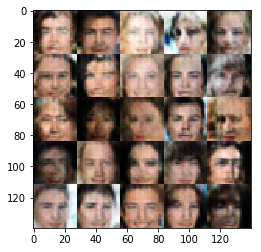

Epoch 1/1... Step 3025... Discriminator Loss: 1.4043... Generator Loss: 0.8733
Epoch 1/1... Step 3050... Discriminator Loss: 1.4363... Generator Loss: 0.7196
Epoch 1/1... Step 3075... Discriminator Loss: 1.4197... Generator Loss: 0.8123
Epoch 1/1... Step 3100... Discriminator Loss: 1.4050... Generator Loss: 0.7654


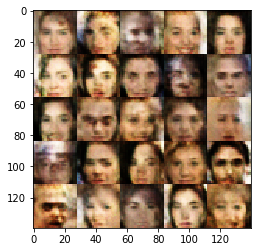

Epoch 1/1... Step 3125... Discriminator Loss: 1.4269... Generator Loss: 0.7592
Epoch 1/1... Step 3150... Discriminator Loss: 1.4241... Generator Loss: 0.7751


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.